# Image Classification of Elephants and Zebras using Neural Networks

### Imports

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from skimage import io,color
from skimage.transform import resize
from skimage.util import crop

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D

from sklearn.preprocessing import Normalizer

## Data Analysis
The data will be loaded into three sets upon which our analysis will take place, namely the training, validation and test sets. Each of the models will be fit on the training data and their respective accuracies will calculated by how close the model's predictions come to the validation set. The test set is reserved for comparing different models with each other to ultimately choose the best model.

A sample plot of the images will be created so that we may get a sense of the input data for this image classification problem.

### Display a sample of the images

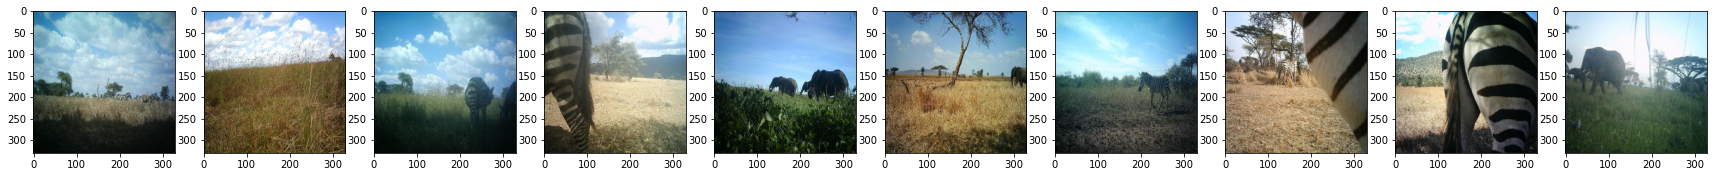

In [8]:
fig, ax = plt.subplots(1,10, figsize = (30,50))

directory = r'data/Valid'
np.random.seed(2022)
elephant_or_zebra = ['elephant_valid','zebra_valid']

for i in range(10):
    rand_animal =np.random.randint(2)
    folder = os.path.join(directory,elephant_or_zebra[rand_animal])
    rand_image = np.random.randint(1000)
    ax[i].imshow(io.imread(os.path.join(folder,os.listdir(folder)[rand_image])))
    
plt.show()

### Creation of Training, Validation and Testing Sets

In [47]:
category_train_dir_labels = ['Elephant_train', 'Zebra_train']
category_valid_dir_labels = ['Elephant_valid', 'Zebra_valid']
category_test_dir_labels = ['Elephant_test', 'Zebra_test']

train_directory =r'data/train/'
valid_directory =r'data/valid/'
test_directory =r'data/test/'

labels = ['elephant','zebra']

# Training Set

train_data = []

for category_label in category_train_dir_labels:
    folder = os.path.join(train_directory,category_label)
    label=category_train_dir_labels.index(category_label)
    
    for img in os.listdir(folder):
        img_path=os.path.join(folder,img)
        img_arr = color.rgb2gray(resize(io.imread(img_path), (100, 100)))
        train_data.append([img_arr,label])
        if i%5==0:
            img_arr = resize(crop(color.rgb2gray(np.fliplr(io.imread(img_path))),50),(100, 100))
            train_data.append([img_arr, label])
            #img_arr = color.rgb2gray(resize(np.fliplr(crop(io.imread(img_path),50)), (100, 100)))
            #img_arr = color.rgb2gray(resize(np.fliplr(crop(io.imread(img_path), 50),(100,100))))
            #train_data.append([img_arr,label])

# Validation Set

valid_data = []
for category_label in category_valid_dir_labels:
    folder = os.path.join(valid_directory,category_label)
    label=category_valid_dir_labels.index(category_label)
    
    for img in os.listdir(folder):
        
        img_path=os.path.join(folder,img)
        img_arr = color.rgb2gray(resize(io.imread(img_path),(100,100)))
        valid_data.append([img_arr,label])
        
# Testing Set

test_data = []
for category_label in category_test_dir_labels:
    folder = os.path.join(test_directory,category_label)
    label=category_test_dir_labels.index(category_label)
    
    for img in os.listdir(folder):
        img_path=os.path.join(folder,img)
        img_arr =color.rgb2gray(resize(io.imread(img_path),(100,100)))
        
        test_data.append([img_arr,label])

Note: One of the image files was corrupt and has been excluded from the data.

There were 13999 images with unique identifiers. Each image is 330x330 pixels and are in full colour.
The images were split as follows:

    Elephants:
        Training:     0 - 5000
        Validation:   5000 - 5999
        Testing:      60000 - 6999
        
    Zebras:
        Trainging:    7000 - 11999
        Validation:   12000 - 12999
        Testing:      13000 - 13999

A sample of these images were plotted to get a sense of the dataset, specifically its dimensions and colour characteristics.

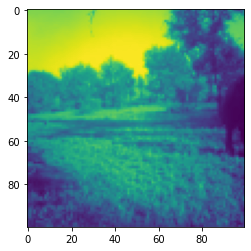

In [48]:
plt.imshow(test_data[0][0])

## Data Augmentation
The training data consists of 10000 images. We decided that this was just about sufficient, however, to augment the data, we will transform 2000 of the training samples using two methods. They will be flipped as well as cropped (and zoomed in on) to ensure that they are different enough from the given training data. This number was kept relatively low to avoid overfitting to the training data. For convenience these steps were completed as the images were read into the training data. 

## Data Preparation
The original data was 330x330 pixels. Considering that we intend to define neural networks to classify these images, it would be beneficial to resize the images. This is because each pixel increases the dimension of the input and layers with more nodes will be required to extract insightful information from the images. This not only increases the complexity of the model, it also increases the time required for computation. Thus, the images were resized to 100x100 pixels; this was done when reading in the images for convenience.

Furthermore, the original images were in full colour. Given that the likely distinctions between the elephants and zebras will be lie in the differing patterns (striped vs monochrome) we can convert the images to grayscale. A great benefit to doing this is that each sample image will have its dimension reduced, specifically (R, G, B) → (value). This was done when reading in the images for convenience.

In the dataset, the images are indexed so that the elephants are grouped separately from the zebras, however, for the models to be trained well, it will be of benefit to first shuffle (randomize the order of) the input images so that the models do not fit to all of one category first and give weight to patterns which are irrelevant to discrimitating between the categories, elephant and zebra.

At this point, the images are stored in a list and the Neural Network models require the data to be in arrays, so these will be converted to numpy arrays.

### Shuffle the Data Order

In [49]:
random.seed(2022)
random.shuffle(train_data)
random.shuffle(test_data)
random.shuffle(valid_data)

### Conversion to Arrays

In [51]:
X_train = []
y_train = []
for feature, label in train_data:
    X_train.append(feature)
    y_train.append(label)

X_valid = []
y_valid = []
for feature, label in valid_data:
    X_valid.append(feature)
    y_valid.append(label)

X_test = []
y_test = []
for feature, label in test_data:
    X_test.append(feature)
    y_test.append(label)

X_train = np.array(X_train).reshape(len(X_train), 100, 100, 1)
y_train = np.array(y_train).reshape(len(y_train), 1)

X_valid = np.array(X_valid).reshape(len(X_valid), 100, 100, 1)
y_valid = np.array(y_valid).reshape(len(y_valid), 1)

X_test = np.array(X_test).reshape(len(X_test), 100, 100, 1)
y_test = np.array(y_test).reshape(len(y_test), 1)

# Dimension Check
print(X_train.shape)

(9999, 100, 100, 1)


This dimension check was done to ensure that the correct number of images are in the training set and that they are the correct size. Since there 10000 images, one of which was corrupt, and we augmented the training data with a further 2000 transformed images, the number of images is correct. Also, the dimensions of each image is correct and we can proceed.

### Display Sample of Prepared Data

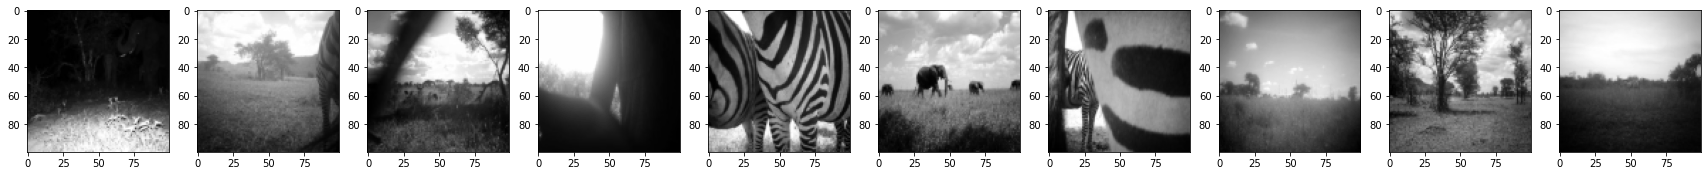

In [54]:
fig, ax = plt.subplots(1,10, figsize = (30,30))

for i in range(10):
    rand_image = np.random.randint(2000)
    ax[i].imshow(X_valid[rand_image],cmap=plt.cm.gray)
    
plt.show()

## Model Choice
The use of a Convoluted Neural Network (CNN) is the industry standard for image classification. Therefore, rather than using different types of Neural Networks, we intend to use multiple CNNs with layers in different configurations. The layers we are considering are:

    > Dense Layer (Dense): fully connected layer constructed using a linear operation that maps every input to the output (i.e. each input is considered in determining the output). 
    
    > Convolutional Layer (Conv2D): creates a mapping of the original image that looks for patterns such as edges by grouping inputs; this type of layer has fewer parameters than a Dense layer with the same number of nodes and thus adds less complexity to the model.
    
    > Pooling Layer (MaxPool2D): groups inputs in the same region and assigns one value to the group, thereby simplifying the input; this also serves to lessen the complexity of the model.
    
    > Flatten Layer (Flatten): converts the output of the Convolutional Layer to a form that is interpretable by the Dense Layer, thereby acting as a bridge between these two layers.
    
Two such models of varying complexities will be considered.

The process of adding layers (increasing complexity) in this way can be generalized and so a function will be written to create and compile the models.

### Function for Creating and Compiling the Models

In [74]:
def createModel(opt = 'adam',number_of_layers = 2):
    
    model = Sequential()
    for i in range(number_of_layers):
        model.add(Conv2D(32,(3,3),activation='relu',padding='same', input_shape = (100,100,1)))
        model.add(MaxPool2D((2,2)))
    model.add(Flatten())
    #model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu', input_shape=(1,)))
    model.add(Dense(1,activation='softmax'))
    model.compile(optimizer=opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    print('Model Summary:')
    print(model.summary())
    
    return model

In [75]:
cnn1 = createModel(number_of_layers=1)
history1 = cnn1.fit(X_train, y_train, epochs = 10,validation_data=(X_valid, y_valid), batch_size=64)

Model Summary:
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 100, 100, 32)      320       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 80000)             0         
_________________________________________________________________
dense_31 (Dense)             (None, 64)                5120064   
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 65        
Total params: 5,120,449
Trainable params: 5,120,449
Non-trainable params: 0
_________________________________________________________________
None
Train on 9999 samples, validate on 2000 samples
Epoch 1/10
9999/9999 [===================

softmax - low accuracy
sigmoid, 1 layer - high accuracy
sigmoid, 2 layers - high accuracy
sgd (accuracy high but val_accuracy very low → overfitting to training data)
therefore, choose sigmoid 1 layer (high accuracy, less complexity)

tuning: take the best model and choose the number of epochs recommended by the graph